# Interpolación de contaminantes

Este notebook muestra el proceso que se sigue para trabajar con los datos de contaminación atmosférica de las estaciones de monitoreo de la Secretaría de Medio Ambiente y Desarrollo Territorial del Estado de Jalisco. Los datos con los que se trabaja fueron recopilados del portal de datos abiertos, verificados y procesados, y actualmente se encuentran guardados en la base de datos del proyecto [Prototipos de Infraestructura Pública para una Ciudad del Futuro](https://pipciudadfuturo.com/).

El notebook consta de las siguientes partes:

+ Librerías utilizadas
+ Descarga de datos
+ Interpolación de niveles de contaminantes en punto dado
+ Visualización de datos
+ Guardado de datos

## Librerías

Para interactuar con la base de datos y generar el procesmiento de los diferentes datos hemos desarrollado una librería propia `aqiGDL` que almacena las diferentes funciones que son requeridas para el trabajo. Además de la librería desarrollada por [LAC](https://lac.mx) para el proyecto, también se utilizan otras librerías de python para el análisis y visualización de datos.

In [ ]:
!pip install osmnx
!pip install requests
!pip install movingpandas

In [ ]:
!git clone https://github.com/lac-analytics/gdlaire.git

#### *Antes de correr el código es necesario dirigirse a la carpeta gdlaire/aqiGDL y posteriormente al archivo data.py. En este es necesario agregar un símbolo de # a la línea de código: from datosgobmx import client. Con esto se comenta este módulo que no se podrá cargar en nuestro Notebook:
+ #from datosgobmx import client

In [8]:
import os
import sys
import osmnx as ox
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import osgeo.gdal
import urllib.request
import zipfile

from google.colab import drive
sys.path.append('/content/gdlaire/')
import aqiGDL

%matplotlib inline

### Estilos visuales
Utilizamos el estilo visual "Pitaya Smoothie" para la generación de gráficas.

In [ ]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
colors = ['7A76C2', 'ff6e9c98', 'f62196', '18c0c4', 'f3907e', '66E9EC']

## Descarga de datos

### Datos históricos de calidad del aire

Los datos históricos de calidad del aire para el Área Metropolitana de Guadalajara ya han sido descargados de las bases de datos de SEMADET. Una vez descargados fueron procesado (revisión de fechas, otuliers, etc.) y validados para ser utilizados. Actualmente los datos limpios están disponibles desde la base de datos de PIP.

Con la siguiente línea de código se realiza la descarga de datos históricos desde el 31 de Diciembre del 2013 al 31 de Diciembre del 2019.

In [9]:
df = aqiGDL.download_simaj_clean_data()

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### Red vial de Guadalajara

Utilizaremos la red vial para generar las gráficas y ubicar el punto de interés.

In [ ]:
G = ox.graph_from_bbox(20.751857,20.523110,-103.201328,-103.468643)
edges = ox.graph_to_gdfs(G, nodes=False)
edges = ox.project_gdf(edges,to_crs='EPSG:32613')

## Creación de punto de interés

Para obtener el dato específico de la calidad del aire en un punto dado de la ciudad es necesario obtener las coordenadas y crear un GeoDataFrame que nos permitirá hacer la interpolación de los datos.

La siguiente función genera este GeoDataFrame

In [ ]:
def location(lon, lat, name):
    
    if lon > -103.51 and lon < -103.2 and lat > 20.49 and lat < 20.791:

        gdf_point_user = pd.DataFrame({'NAME': name, "x": [lon], "y": [lat]})
        geometry_ = gpd.points_from_xy(gdf_point_user.x, gdf_point_user.y)

        gdf_point_user = gpd.GeoDataFrame(gdf_point_user, geometry=geometry_ ,crs="EPSG:4326")
        gdf_point_user = ox.project_gdf(gdf_point_user, to_crs='EPSG:32613')

        return gdf_point_user
    
    else:
        
        gdf_point_user = pd.DataFrame()
        
        print ('Las coordenadas están fuera del área de interpolación. Selecciona otro punto.')
        
        return gdf_point_user

In [ ]:
lon = -103.3912464	
lat = 20.7220764
name = "Mercado Municipal de Zapopan"
gdf_location = location(lon, lat, name)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
edges.plot(ax=ax, color='#e8e9eb',linewidth=0.1, zorder=-1)
edges[(edges['highway']=='primary') | (edges['highway']=='secondary')].plot(ax=ax, color='#e8e9eb',linewidth=0.5, zorder=0)
gdf_location.plot(ax=ax, color='#ba0d38', alpha=0.85, zorder=2, markersize=120)
ax.axis('off')
fig.suptitle(f'Ubicación:\n{name}', fontsize=25);

NameError: ignored

ImportError: ignored

<Figure size 720x720 with 1 Axes>

## Interpolación

Una vez que tenemos los datos de contaminantes y la ubicación que nos interesa analizar, el siguiente paso es generar la [interpolación](https://es.wikipedia.org/wiki/Interpolaci%C3%B3n) de valores en ese punto.

La siguiente función iterata sobre todas las fechas en las que se tienen registros de contaminantes y sobre todos los contaminantes por fecha. Hacemos esto para obtener el valor de $x$ contaminante en cada fecha en la ubicación dada. La función llama a su vez a una función 'aqiGDL.interpolate_atpoint()' que realiza las operaciones necesaras para obtener los valores.

In [ ]:
def calculate_interpolation_values(gdf_location, df):

    #Create dataframe to store interpolation results
    df_location_results = pd.DataFrame(columns=['FECHA', 'PARAM', 'NAME', 'CONC', 'LONG', 'LAT'])

    df_location = gdf_location.drop(columns=['geometry'], inplace=False)

    empty0 = ''  # string used for logging empty values
    i = 0
    #interpolation, has to be done for each data for each value.
    for d in df.FECHA.unique():
        for p in df.PARAM.unique():
            #In case more than one location are specified.
            for l in df_location.NAME.unique():
                # coordinates for interpolation
                lon_int = df_location.loc[df_location.NAME == l]['x'].iloc[0]
                lat_int = df_location.loc[df_location.NAME == l]['y'].iloc[0]
                simaj = df.loc[(df.FECHA == d) & (df.PARAM == p)]
                # interpolate concentration
                c = aqiGDL.interpolate_atpoint(lon_int, lat_int, simaj)
                if c == -1:
                    empty1 = (f'Empty value at parameter: {p}, date: {d}')
                    # checks if a parameter for a specified date is empty, so it doesn't repeat the log
                    if empty0 != empty1:
                        empty0 = empty1
                    c = np.nan
                df_location_results.loc[i] = [d, p, l, c, lon_int, lat_int]
                i += 1
    df_location_results.FECHA = pd.to_datetime(df_location_results.FECHA)
    df_location_results.set_index('FECHA',inplace=True)
    return df_location_results

### Resultados

Los resultados de la interpolación se obtienen por día y contaminante en la ubicación seleccionada. A continuación mostramos los primeros diez valores de la tabla.

In [ ]:
df_location_results = calculate_interpolation_values(gdf_location, df)
df_location_results.head(10)

Agrupamos los datos por semanas para poder visualizar mejor el cambio en los contaminantes y los patrones:

In [ ]:
df_week = aqiGDL.week_average(df_location_results,'NAME')
df_week.head(10)

NameError: ignored

## Visualización de datos
A partir de los datos obtenidos de la interpolación podemos visualizar como han cambiado los contaminantes a lo largo de los años.

La siguiente función procesa la base de datos y genera un panel de visualizaciones.

In [ ]:
def plot_data(df_week, name, edges):
    fig, axes = plt.subplots(2,3,figsize=(24,14), sharex=True)
    for param, ax, color in zip(df_week.PARAM.unique().tolist(), axes.flatten()[1:], colors):
        df_temp = df_week[(df_week['NAME']==name) & (df_week['PARAM']==param)]
        ax.plot(df_temp['S_YEAR'], df_temp['CONC'], label=param, color='#'+color)
        ax.fill_between(range(len(df_temp)), 
                               df_temp['STD']*-1+df_temp['CONC'], 
                                df_temp['STD']*1+df_temp['CONC'], 
                               facecolor='#9ddc9b', 
                               alpha=0.25)

        ax.set_title(param,fontsize=20)
        ax.tick_params(axis='x',labelrotation=45)


    x_ticks = np.arange(0, len(df_temp['S_YEAR']),15)
    for i in range(0,3):
        plt.sca(axes[1, i])
        plt.xticks(x_ticks, horizontalalignment="right");
    a00 = axes[0,0]
    shax = a00.get_shared_x_axes()
    shax.remove(a00)
    edges.plot(ax=a00, color='#e8e9eb',linewidth=0.1, zorder=-1)
    edges[(edges['highway']=='primary') | (edges['highway']=='secondary')].plot(ax=a00, color='#e8e9eb',linewidth=0.5, zorder=0)
    gdf_location.plot(ax=axes[0][0], color='#ba0d38', alpha=0.85, zorder=2, markersize=90)
    axes[0][0].axis('off')
    fecha_1 = '2014-01-01'
    fecha_2 = '2019-12-31'
    fig.suptitle(f'{name}\n{fecha_1} -- {fecha_2}', fontsize=30)

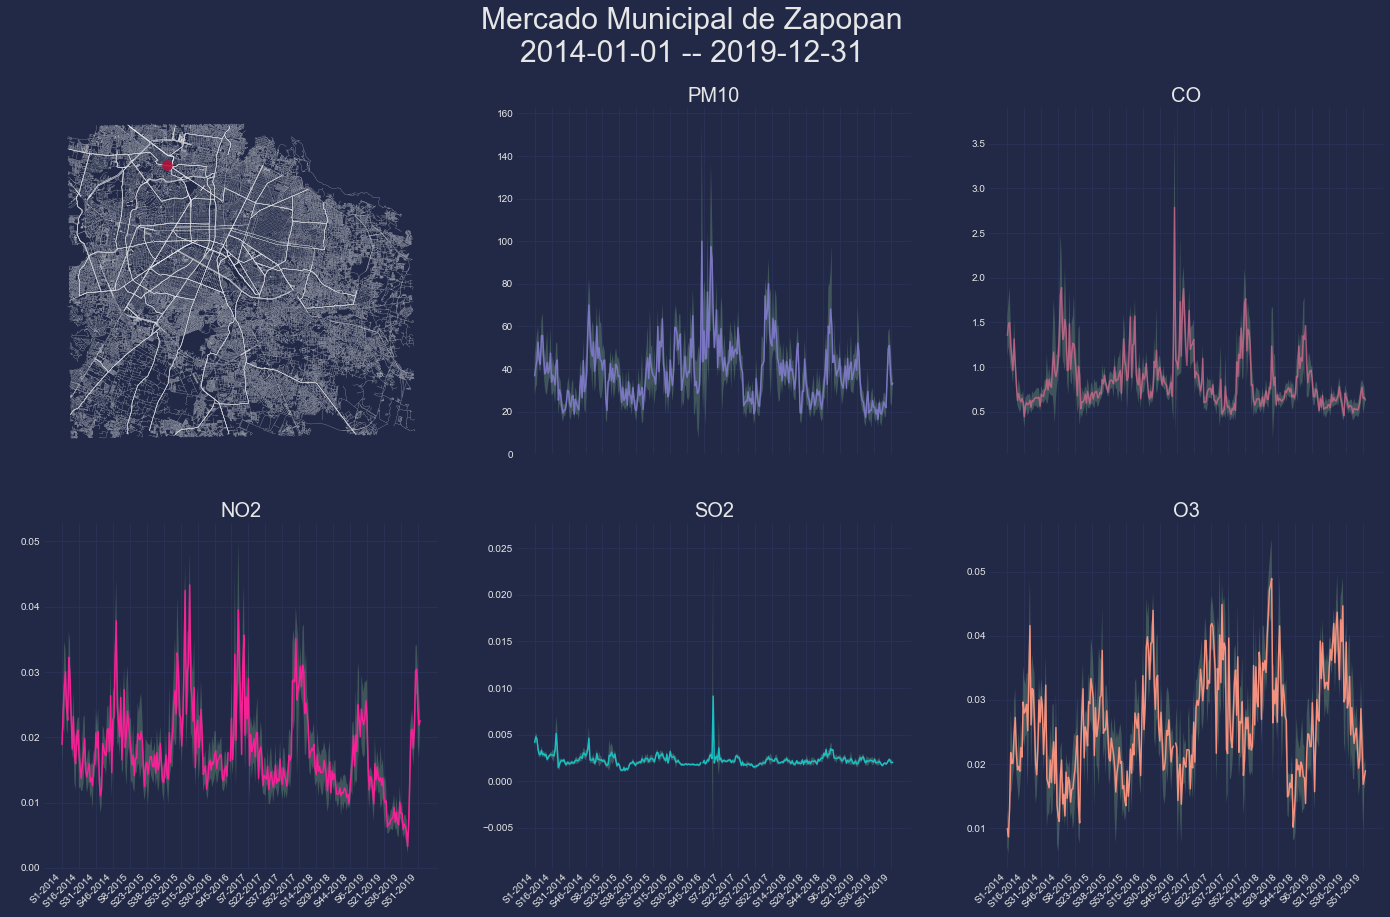

In [ ]:
plot_data(df_week, name, edges)

## Guardar datos

El último paso es guardar los datos para poder generar otros análisis, para esto podemos guardar las diferentes bases de datos:

### Ubicación

In [ ]:
gdf_location.to_file(f'{name}.geojson',driver='GeoJSON')

### Datos de contaminantes por estaciones de monitoreo

In [ ]:
df.to_csv('Mediciones_Estaciones_SIMAJ.csv')

### Datos de contaminantes interpolados a ubicación por día

In [ ]:
df_location_results.to_csv(f'Resultados_interpolacion_{name}_dia.csv')

### Datos de contaminantes interpolados a ubicación por semana

In [ ]:
df_week.to_csv(f'Resultados_interpolacion_{name}_semana.csv')